In [1]:
from keras.models import load_model

import pickle
import cv2
import h5py
import glob
import numpy as np
import natsort

from utils.generator import Generator
from utils.aspect_aware_resize import AspectAwareResize
from utils.mean_subtract import MeanSubtract

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/home/yq/miniconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/yq/miniconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def intersection_over_union(A, B):       # IoU = (Area of Overlap) / Area of Union
    xA = max(A[0], B[0])
    yA = max(A[1], B[1])
    xB = min(A[2], B[2])
    yB = min(A[3], B[3])
    
    # computer area of intersection 
    interArea = max(0, xB-xA+1) * max(0, yB-yA+1)
    
    # compute area of both boxes
    AArea = (A[2]-A[0]+1) * (A[3]-A[1]+1)
    BArea = (B[2]-B[0]+1) * (B[3]-B[1]+1)
    
    iou = interArea / float(AArea + BArea - interArea)
    
    return iou

### Making predictions

In [3]:
BS = 128

model = load_model("detection.h5")

with h5py.File("bbox/test.hdf5", "r") as f:
    labels = f["labels"][()]

means = pickle.load(open("rgb_means.pkl", "rb"))
aar = AspectAwareResize(96, 96)
ms = MeanSubtract(means["R"], means["G"], means["B"])
preprocessors = [aar, ms]
gen = Generator("bbox/test.hdf5", BS, 1, preprocessors)

In [4]:
predictions = model.predict_generator(gen.generate(), steps=(gen.n_img//BS)+1)
losses = model.evaluate_generator(gen.generate(), steps=(gen.n_img//BS)+1)
gen.close()

print("Test loss: {}".format(losses))

Test loss: 236.225480141828


### Evaluating the model with IoU

In [5]:
IoU_list = []

for i, (label, pred) in enumerate(zip(labels, predictions)):
    iou = intersection_over_union(label, pred)
    IoU_list.append(iou)
    
IoU = sum(IoU_list)/(i+1)

print("Average IoU: {}".format(IoU))

Average IoU: 0.33743688168155417


### Some visualization again

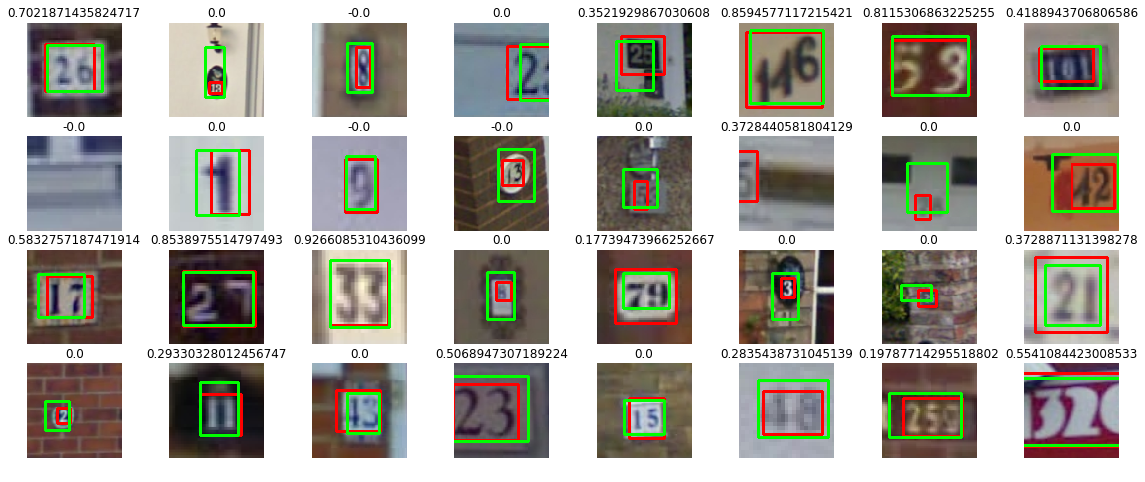

In [9]:
test_paths = natsort.natsorted(glob.glob("test/*.png"))

idxs = np.random.choice(len(test_paths), size=32)

fig = plt.figure(figsize=(20, 8))
for n, i in enumerate(idxs):
    img = cv2.imread(test_paths[i])
    img = aar.preprocess(img)
    label = labels[i]
    pred = predictions[i]
    
    # ground truth  RED
    cv2.rectangle(img, (label[0], label[1]), (label[0]+label[2], label[1]+label[3]), (0, 0, 255), 2)
    # prediction    GREEN
    cv2.rectangle(img, (pred[0], pred[1]), (pred[0]+pred[2], pred[1]+pred[3]), (0, 255, 0), 2)
        
    plt.subplot(4, 8, n+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(IoU_list[i])
    
plt.show()